In [3]:
# import packages

from pyfar import Signal
import numpy as np
import cmath
from scipy.special import legendre, hankel1

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

ModuleNotFoundError: No module named 'deepdiff'

In [8]:
# run this inside your environment to test if pyfar is installed
# python your/path/to/test_pyfar.py

fs = 44100
x = np.zeros(44100)
x[0] = 1
x_energy = Signal(x, fs)

# show information
print(x_energy)

time domain energy Signal:
(1,) channels with 44100 samples @ 44100 Hz sampling rate and none FFT normalization



In [9]:
a = 0.1     # radius of the sphere (m)
r = 5      # distance from the center of the sphere to the source (m)
theta = 10 # angle of incidence (rad)
f = 500    # frequency (Hz)
c = 343    # ambient speed of sound (m/s)

def hankel_der(x, m): # scipy hankel
    """m th-order spherical Hankel function h_m.

    Parameters:
    x (int): the real part (default 0.0)
    M (int): order

    Returns:
    h_m (float): derivation of spherical Hankel function
    """

    h_m = (x+1j)*cmath.exp(1j*x-(1j*np.pi*m)/2)/ x**2  # derivation
    return h_m

def spherical_head(f, a, m, theta):
    """Calculate transfer function.

    Parameters:
    f (int): frequency
    a (int): radius
    m (int): order
    theta (float): angle

    Returns:
    H (float): head-related transfer function
    """

    c = 343
    mu = (f*2*np.pi*a)/c

    f = ((-1j)**(m-1))*(2*m+1)*legendre(m)*np.cos(theta)/hankel_der(mu,m)
    h_upper = (1/mu**2) * np.array([f(t) for t in range(1, m + 1)]).sum()

    return print(h_upper)

m = 100  # infinity
    
# run HRTF
spherical_head(f, a, m, theta)



(nan+nanj)


/opt/miniconda3/envs/pyfar/lib/python3.8/site-packages/scipy/special/orthogonal.py:2081: RuntimeWarning: overflow encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/opt/miniconda3/envs/pyfar/lib/python3.8/site-packages/scipy/special/orthogonal.py:2081: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n


## Duda (1998) HRTF Algorithm Appendix B

In [16]:
def hrtf(a, r, theta, f, c, threshold):
    x = np.cos(theta)
    mu = (2 * np.pi * f * a) / c
    rho = r / a
    zr = 1 / (1j * mu * rho)
    za = 1 / (1j * mu)
    qr2 = zr
    qr1 = zr * (1 - zr)
    qa2 = za
    qa1 = za * (1 - za)
    p2 = 1
    p1 = x
    summ = 0
    term = zr / (za * (za - 1))
    summ = summ + term
    term = (3 * x * zr * (zr - 1)) / (za * (2 * (za ** 2) - 2 * za + 1))
    summ = summ + term
    oldratio = 1
    newratio = np.abs(term) / np.abs(summ)
    m = 2
    
    while (oldratio > threshold) or (newratio > threshold):
        qr = - (2 * m - 1) * zr * qr1 + qr2
        qa = - (2 * m - 1) * za * qa1 + qa2
        p = ((2 * m - 1) * x * p1 - (m - 1) * p2) / m
        term = ((2 * m + 1) * p * qr) / ((m + 1) * za * qa - qa1)  # might become NaN for low frequencies
        summ = summ + term
        m = m + 1
        qr2 = qr1
        qr1 = qr
        qa2 = qa1
        qa1 = qa
        p2 = p1
        p1 = p
        oldratio = newratio
        newratio = np.abs(term) / np.abs(summ)
    else:
        h_upp = (rho * cmath.exp(-1j * mu) * summ) / (1j * mu)
        h_upp_dB = 20*np.log(np.abs(h_upp)/(1))  # what's supposed to be in the denominator
    return h_upp_dB


threshold = 5 # which value?!

# run HRTF
hrtf(a, r, theta, f, c, threshold)

TypeError: unsupported operand type(s) for /: 'list' and 'float'

## Calculate dB Responses

In [17]:
a = 0.1     # radius of the sphere (m)
r = [1e16, 0.8, 0.4, 0.2, 0.15, 0.125]      # distance from the center of the sphere to the source (m)
theta = [0, 150]  # angle of incidence (rad)
c = 343    # ambient speed of sound (m/s)

# info prints
f_low = round((0.1*c)/(2*np.pi*a), 2)
print(f'f bei 0.1 mu: {f_low} Hz')

f_hi = round((100*c)/(2*np.pi*a), 2)  # isn't this too high?!
print(f'f bei 100 mu: {f_hi} Hz')

mu_20k = (2*np.pi*20000*a)/c
print(f'mu bei 20 kHz: {mu_20k}')

# create frequency / mu vector
freq_vec = np.linspace(f_low, f_hi, 2000)
mu_freq_vec = (2*np.pi*freq_vec*a)/c

# calculate HRTF
freq_dB = []

for t in theta:
    #print(f'theta: {t}')
    for rr in r:
        #print(f'r: {rr}')
        for val in freq_vec:
            freq_dB.append(hrtf(a, rr, t, val, c, threshold))
            
print(f'freq_dB max: {round(max(freq_dB),1)} dB, freq_dB min: {round(min(freq_dB),1)} dB')

f bei 0.1 mu: 54.59 Hz
f bei 100 mu: 54590.15 Hz
mu bei 20 kHz: 36.63664902145532
freq_dB max: 17.1 dB, freq_dB min: -69.5 dB


## Plot

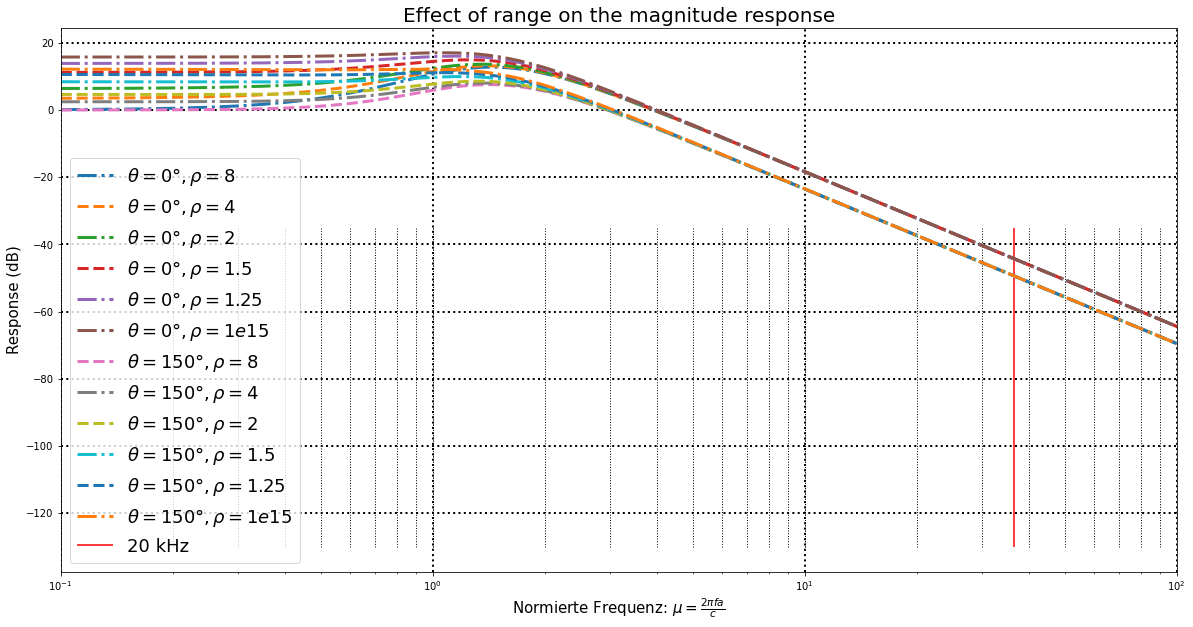

In [14]:
len_plot = int(len(freq_dB)/(len(r)*len(theta)))
l_size = 3

plt.figure(figsize=(20,10))
plt.semilogx(mu_freq_vec, freq_dB[:len_plot], '-.', linewidth=l_size, label=r'$ \theta = 0°, \rho = 8$')
plt.semilogx(mu_freq_vec, freq_dB[len_plot:len_plot*2], '--', linewidth=l_size, label=r'$ \theta = 0°, \rho = 4$')
plt.semilogx(mu_freq_vec, freq_dB[len_plot*2:len_plot*3], '-.', linewidth=l_size, label=r'$ \theta = 0°, \rho = 2$')
plt.semilogx(mu_freq_vec, freq_dB[len_plot*3:len_plot*4], '--', linewidth=l_size, label=r'$ \theta = 0°, \rho = 1.5$')
plt.semilogx(mu_freq_vec, freq_dB[len_plot*4:len_plot*5], '-.', linewidth=l_size, label=r'$ \theta = 0°, \rho = 1.25$')
plt.semilogx(mu_freq_vec, freq_dB[len_plot*5:len_plot*6], '-.', linewidth=l_size, label=r'$ \theta = 0°, \rho = 1e17$')
plt.semilogx(mu_freq_vec, freq_dB[len_plot*6:len_plot*7], '--', linewidth=l_size, label=r'$ \theta = 150°, \rho = 8$')
plt.semilogx(mu_freq_vec, freq_dB[len_plot*7:len_plot*8], '-.', linewidth=l_size, label=r'$ \theta = 150°, \rho = 4$')
plt.semilogx(mu_freq_vec, freq_dB[len_plot*8:len_plot*9], '--', linewidth=l_size, label=r'$ \theta = 150°, \rho = 2$')
plt.semilogx(mu_freq_vec, freq_dB[len_plot*9:len_plot*10], '-.', linewidth=l_size, label=r'$ \theta = 150°, \rho = 1.5$')
plt.semilogx(mu_freq_vec, freq_dB[len_plot*10:len_plot*11], '--', linewidth=l_size, label=r'$ \theta = 150°, \rho = 1.25$')
plt.semilogx(mu_freq_vec, freq_dB[len_plot*11:len_plot*12], '-.', linewidth=l_size, label=r'$ \theta = 150°, \rho = 1e17$')
plt.xlim([0.1,100])

# vertical lines
position1 = np.arange(0.1, 1.1, step=0.1)
position2 = np.arange(1, 11, step=1)
position3 = np.arange(10, 110, step=10)
position = list(position1) + list(position2) + list(position3)
for tick in position:
    plt.vlines(tick, -130, -35, colors='k', linestyle=':', linewidth=1)
    
plt.vlines(mu_20k, -130, -35, colors='r', linestyle='-', linewidth=1.5, label='20 kHz')
plt.grid(color='k', linestyle=':', linewidth=2)

# plt.ylim(-130, -35)
plt.title('Effect of range on the magnitude response', fontsize=20)
plt.ylabel('Response (dB)', fontsize=15)
plt.xlabel(r'Normierte Frequenz: $\mu = \frac{2\pi fa}{c}$', fontsize=15)
plt.legend(prop={'size': 18})
plt.show()

## Test NaN

In [16]:
import numpy as np

mylist = [3, 4, 5, np.nan]
print(mylist)
l = [x for x in mylist if ~np.isnan(x)]
print(l)

[3, 4, 5, nan]
[3, 4, 5]


## Off Ear

In [32]:
r = 5   # distance to the source to the center of the sphere
r0 = 1  # distance of the source to the origin of co-coordinates
mu = (2 * np.pi * f * a) / c
theta = 95

roh = r/a
roh0 = r0/a

def off_ear(roh,roh0,mu,theta,m):
    factor = (roh0/(1j*mu))*cmath.exp(1j*(mu*roh - mu*roh0 - mu))
    summ = 0
    for i in range(1, m+1):
        summ += (2*m + 1)*legendre(m)*np.cos(theta)* hankel1(m,1/(1j*mu*roh))/((m+1/(1j*roh))*hankel1(m,1/(1j*roh))-hankel1(m-1,1/(1j*roh)))
    hrtf = factor * summ
    return hrtf

hrtf_off = off_ear(roh, roh0, mu, theta, m)
print(hrtf_off)

              100                99                98                97
(nan + nanj) x   + (nan + nanj) x  + (nan + nanj) x  + (nan + nanj) x 
                 96                95                94
 + (nan + nanj) x  + (nan + nanj) x  + (nan + nanj) x 
                 93                92                91
 + (nan + nanj) x  + (nan + nanj) x  + (nan + nanj) x 
                 90                89                88
 + (nan + nanj) x  + (nan + nanj) x  + (nan + nanj) x 
                 87                86                85
 + (nan + nanj) x  + (nan + nanj) x  + (nan + nanj) x 
                 84                83                82
 + (nan + nanj) x  + (nan + nanj) x  + (nan + nanj) x 
                 81                80                79
 + (nan + nanj) x  + (nan + nanj) x  + (nan + nanj) x 
                 78                77                76
 + (nan + nanj) x  + (nan + nanj) x  + (nan + nanj) x 
                 75                74                73
 + (nan + nanj) x  + (na

/opt/miniconda3/envs/pyfar/lib/python3.8/site-packages/scipy/special/orthogonal.py:2081: RuntimeWarning: overflow encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/opt/miniconda3/envs/pyfar/lib/python3.8/site-packages/scipy/special/orthogonal.py:2081: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
